In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
import datetime
import yfinance as yf

In [36]:
#https://finance.yahoo.com/most-active/heatmap


symbols = ["IVV", "BRK-B", "JPM"]

symbols = list(set(symbols))

symbols.sort()

def get_history(*symbols):
    dfs = []
    for symbol in symbols:
        hist = yf.Ticker(symbol).history(period="10y")
        rename = {col: f"{symbol}_{col}" for col in hist.columns}
        hist = hist.rename(columns=rename)
        hist = hist.sort_index()
        #hist
        #close = hist[f"{symbol}_Close"].values
        #delta = close[1:] - close[:-1]
        #hist[f"{symbol}_Delta"] = [None] + list(delta)
        #hist[f"{symbol}_Return"] = [None] + list(delta / close[:-1])
        #hist = hist.dropna()
        hist = hist[[f"{symbol}_Close"]]#, f"{symbol}_Delta", f"{symbol}_Return"]]
        #hist
        dfs.append(hist)
        
    df = dfs[0]
    
    for other in dfs[1:]:
        df = df.merge(other, on="Date")
        
        
    df["Close_Date"] = df.index
    df2 = df.copy()
    df2["Close_Date"] = df2["Close_Date"].apply(lambda x: x - np.timedelta64(7, 'D'))
    mdf = df.merge(df2, on="Close_Date")
    for symbol in symbols:
        mdf[f"{symbol}_Return"] = (mdf[f"{symbol}_Close_y"] - mdf[f"{symbol}_Close_x"]) / mdf[f"{symbol}_Close_x"]
    mdf = mdf[["Close_Date"] + [f"{symbol}_Return" for symbol in symbols] + [f"{symbol}_Close_y" for symbol in symbols]]
    mdf = mdf.rename(columns={f"{symbol}_Close_y": f"{symbol}_Close" for symbol in symbols})
        
    df = mdf.dropna()
    return df

df = get_history(*symbols)
df["Weekday"] = df["Close_Date"].dt.day_name() #values[0].dt#astype(datetime.datetime).isoweekday()
df = df.query("Weekday == 'Friday'").drop(columns=["Weekday"])
df

,Close_Date,BRK-B_Return,IVV_Return,JPM_Return,BRK-B_Close,IVV_Close,JPM_Close
0,2011-05-06,-0.006982,-0.000817,-0.041963,79.650002,110.393044,32.648117
5,2011-05-13,-0.011676,-0.003048,-0.000463,78.720001,110.056511,32.632988
10,2011-05-20,-0.008638,-0.000671,-0.007883,78.040001,109.982674,32.375751
14,2011-05-27,-0.022937,-0.023284,-0.028512,76.250000,107.421883,31.452662
18,2011-06-03,-0.028721,-0.021699,-0.012509,74.059998,105.090904,31.059223
...,...,...,...,...,...,...,...
2396,2021-03-12,-0.034728,-0.008620,-0.006468,250.990005,390.882324,154.231628
2401,2021-03-19,0.023029,0.016802,-0.000322,256.769989,397.450012,154.181915
2414,2021-04-09,0.022931,0.014311,-0.019068,272.109985,418.890015,153.300003
2419,2021-04-16,-0.000478,-0.001385,-0.020287,271.980011,418.309998,150.190002


In [37]:
for col in df.columns:
    print(col, df[col].mean(), df[col].std())

Close_Date 2016-04-10 16:55:57.055214848 1052 days 05:40:14.372282144
BRK-B_Return 0.0023267659226217452 0.02509628020561603
IVV_Return 0.002439474315799924 0.02225855177340654
JPM_Return 0.003331804613079656 0.03635572087964586
BRK-B_Close 152.85329232869216 49.4673862942165
IVV_Close 208.3645921796865 74.30512742741932
JPM_Close 69.00817715463462 32.236545963032015


In [38]:
# https://plotly.com/python/v3/ipython-notebooks/markowitz-portfolio-optimization/

rho 0.754780307357235 1.0020491803278688 0.8448472496743218
rho -0.245219692642765 0.002049180327868827 -0.1551527503256782
cluster 0 ['BRK-B']
cluster 1 ['IVV']
cluster 2 ['JPM']


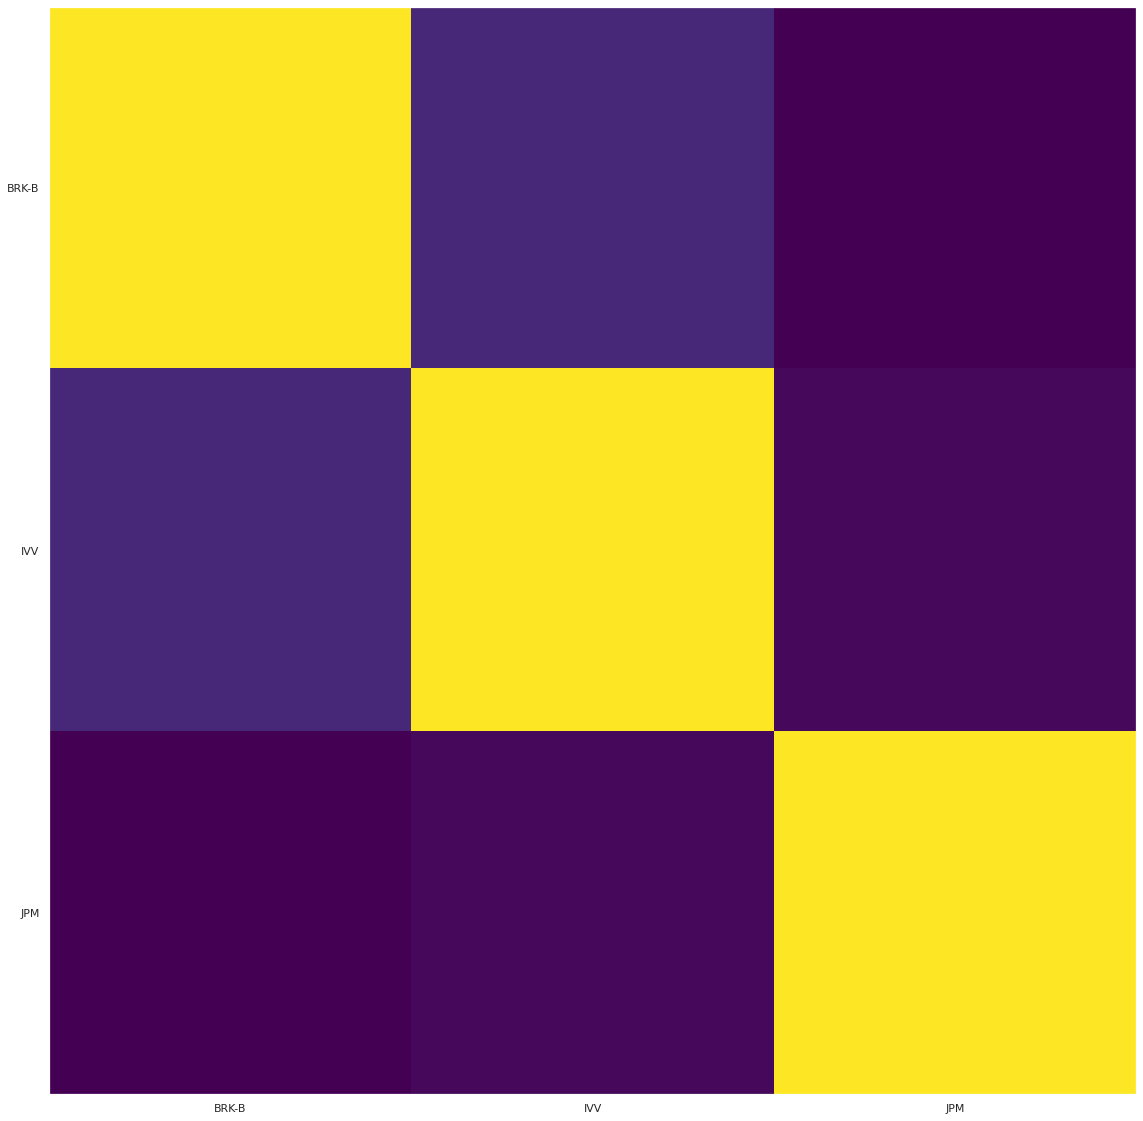

In [39]:
from sklearn.cluster import AffinityPropagation, SpectralClustering

data = np.asmatrix(df[[f"{symbol}_Return" for symbol in symbols]].T)
data = data / np.std(data, axis=1)
rho = np.cov(data)

distance = 1 - rho
affinity = -distance
ap = AffinityPropagation(affinity="precomputed", random_state=None)
#sc = SpectralClustering(affinity="precomputed", random_state=None)
print("rho", rho.min(), rho.max(), rho.mean())
print("rho", affinity.min(), affinity.max(), affinity.mean())
result = ap.fit_predict(affinity)
#print("clusters", result)

clusters = list(set(result))
new_symbols = []

for cluster in clusters:
    for i, cluster_id in enumerate(result):
        if cluster_id == cluster:
            new_symbols.append(symbols[i])
    print("cluster", cluster, [symbol for idx, symbol in enumerate(symbols) if result[idx] == cluster])

data = np.asmatrix(df[[f"{symbol}_Return" for symbol in new_symbols]].T)
data = data / np.std(data, axis=1)
rho = np.cov(data)

plt.figure(figsize=(20,20))
plt.imshow(rho, cmap="viridis")
#plt.axis("off")
ax = plt.gca()
ax.grid(False)
plt.xticks(ticks=range(len(symbols)), labels=new_symbols)
plt.yticks(ticks=range(len(symbols)), labels=new_symbols)
plt.show()

In [40]:
import cvxopt as opt
from cvxopt import blas, solvers

def optimal_portfolio_new(returns, N=50):
    """
    Inspired by
    https://plotly.com/python/v3/ipython-notebooks/markowitz-portfolio-optimization/
    
    QP docs here:
    https://cvxopt.org/userguide/coneprog.html#quadratic-programming
    
    Page 16 here:
    https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwi1ko729-7vAhXigP0HHVSBDAkQFjAAegQIBRAD&url=https%3A%2F%2Fpublikationen.bibliothek.kit.edu%2F1000007246%2F11235&usg=AOvVaw2YCB12QbGK3IhadaGuVk_f
    """
    n = len(returns)
    returns = np.asmatrix(returns)
    
    #N = 1000
    #eps = 1e-1
    #mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    #print(mus)
    mean_returns = np.mean(returns, axis=1)
    
    desired_returns = list(np.linspace(np.min(mean_returns), np.max(mean_returns), num=N))
    
    #mus = list(np.linspace(np.min(mean_returns)+eps, np.max(mean_returns)-eps, num=N))
    #print(mus)
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # qp(P, q, G, h, A, b):
    #     minimize (1/2) x.T * P * x + q.T * x
    #     subject to:
    #         Gx <= h
    #         Ax = b
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    #A = opt.matrix(1.0, (1, n))
    #b = opt.matrix(1.0)
    
    A = np.zeros(shape=(2,n))
    b = np.zeros(shape=(2,))
    
    for i in range(n):
        A[0, i] = 1.0
        A[1, i] = mean_returns[i]
    
    b[0] = 1.0
    b[1] = 0.0
    
    A = opt.matrix(A)
    b = opt.matrix(b)
    
    q = 0*pbar
        
    
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = []
    
    for desired_return in desired_returns:
        b[1] = desired_return
        portfolio = solvers.qp(S, q, G, h, A, b)['x']
        portfolio = np.array(portfolio).reshape(-1, 1)
        portfolios.append(portfolio)
        
    S = np.asmatrix(S)
        
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [np.asscalar(np.dot(mean_returns.transpose(), x)) for x in portfolios]
    risks = [np.asscalar(np.sqrt(np.dot(x.transpose(), S.dot(x)))) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    #m1 = np.polyfit(returns, risks, 2)
    #x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    #wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    #return np.asarray(wt), returns, risks, portfolios
    return returns, risks, portfolios

In [41]:
%%capture
return_vec = np.asmatrix(df[[f"{symbol}_Return" for symbol in symbols]].T)
returns, risks, portfolios = optimal_portfolio_new(return_vec, N=1000)

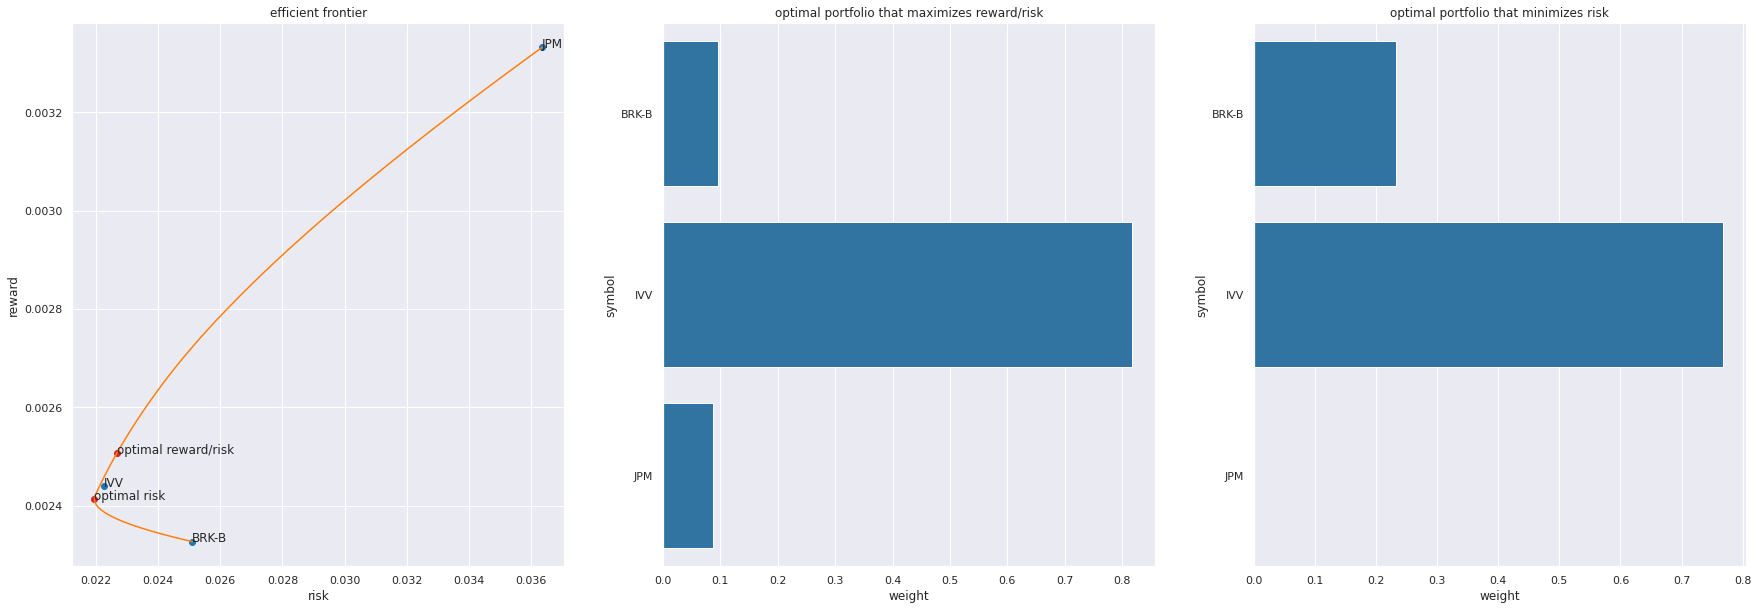

In [42]:
#print(returns, risks)

zipped = list(zip(returns, risks))

opt_reward = returns[np.argmin(risks)]
#print(returns)

data = pd.DataFrame(
    data= {
        "reward": returns,
        "risk": risks,
    }
)

below_data = data.query("reward <= @opt_reward")
above_data = data.query("reward >= @opt_reward")


plt.figure(figsize=(30,10))

plt.subplot(1, 3, 1)

for data in [below_data, above_data]:
    sns.lineplot(x="risk", y="reward", data=data, color="tab:orange")

mean_returns = [df[f"{symbol}_Return"].mean() for symbol in symbols]
mean_risks = [df[f"{symbol}_Return"].std() for symbol in symbols]

plt.scatter(mean_risks, mean_returns, color="tab:blue")

for i, symbol in enumerate(symbols):
    plt.annotate(symbol, (mean_risks[i], mean_returns[i]))
    
idx_rr = np.argmax(np.array(returns) / np.array(risks))
#print(idx)
plt.scatter([risks[idx_rr]], [returns[idx_rr]], color="tab:red")
plt.annotate("optimal reward/risk", ([risks[idx_rr], returns[idx_rr]]))
#print(returns[idx], risks[idx])

idx_rk = np.argmin(np.array(risks))
#print(idx)
plt.scatter([risks[idx_rk]], [returns[idx_rk]], color="tab:red")
plt.annotate("optimal risk", ([risks[idx_rk], returns[idx_rk]]))
#print(returns[idx], risks[idx])

plt.title("efficient frontier")

plt.subplot(1, 3, 2)

data = pd.DataFrame(
    data = {
        "symbol": symbols,
        "weight": [wt for wt in portfolios[idx_rr].reshape(-1)]
    }
)

sns.barplot(y="symbol", x="weight", data=data, color="tab:blue")

plt.title("optimal portfolio that maximizes reward/risk")


plt.subplot(1, 3, 3)

data = pd.DataFrame(
    data = {
        "symbol": symbols,
        "weight": [wt for wt in portfolios[idx_rk].reshape(-1)]
    }
)

sns.barplot(y="symbol", x="weight", data=data, color="tab:blue")

plt.title("optimal portfolio that minimizes risk")


plt.show()

In [44]:
def num_shares(cash, idx):
    weights = portfolios[idx].reshape(-1)
    costs = np.array([df[f"{symbol}_Close"].values[-1] for symbol in symbols])
    portfolio = dict()
    for symbol, weight, cost in zip(symbols, weights, costs):
        shares = round(weight/cost*cash)
        assert weight <= 1
        buy_cost = shares * cost
        
        portfolio[symbol] = {
            "shares": shares,
            "purchase_cost": buy_cost
        }
    return portfolio
    
num_shares(190000, idx_rr)

{'BRK-B': {'shares': 66, 'purchase_cost': 18146.700805664062},
 'IVV': {'shares': 370, 'purchase_cost': 154985.60180664062},
 'JPM': {'shares': 108, 'purchase_cost': 16611.479736328125}}

In [217]:
1.0024**52

1.132752463303942